# Import Necesssary Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model
from pylab import rcParams
rcParams['figure.figsize'] = 5, 2.5

# Importing the Dataset

In [2]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       surprise  fear  angry  neutral   sad  disgust  happy
train      3171  4097   3995     4965  4830      436   7215
      surprise  fear  angry  neutral   sad  disgust  happy
test       831  1024    958     1233  1247      111   1774


# Basic Plots for the Data

<Axes: >

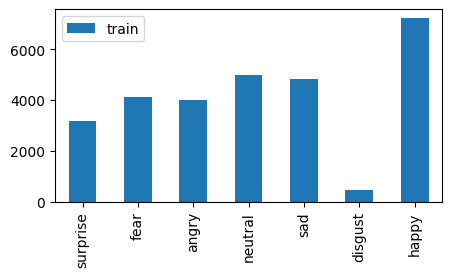

In [3]:
train_count.transpose().plot(kind='bar')

<Axes: >

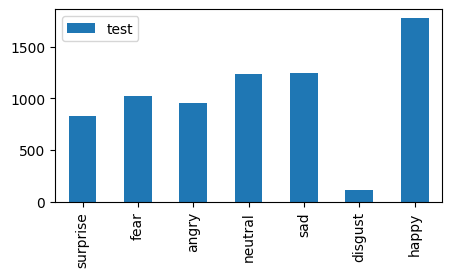

In [4]:
test_count.transpose().plot(kind='bar')

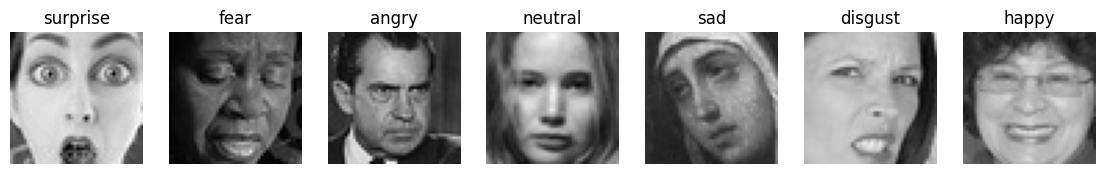

In [5]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

# Creating Training and Testing Sets

In [6]:
'''
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')
'''

from keras.applications.vgg19 import preprocess_input


train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(224, 224),  # Update target size to (224, 224)
                                                shuffle=True,
                                                class_mode='categorical')  # Remove color_mode parameter

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                            batch_size=64,
                                            target_size=(224, 224),  # Update target size to (224, 224)
                                            shuffle=True,
                                            class_mode='categorical')  # Remove color_mode parameter


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

# Define the Model

In [8]:
'''
def create_model():
    input_shape=(48,48,3)

    model = Sequential()
    model.add(Dense(2304, activation = 'relu'))
    model.add(Conv2D(4, (2, 2), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (2, 2), padding='same', activation = 'relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (2, 2), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='Adam')
    
    return model
'''

"\ndef create_model():\n    input_shape=(48,48,3)\n\n    model = Sequential()\n    model.add(Dense(2304, activation = 'relu'))\n    model.add(Conv2D(4, (2, 2), input_shape=input_shape, padding='same', activation = 'relu'))\n    model.add(MaxPooling2D(pool_size=(2, 2)))\n\n    model.add(Conv2D(16, (2, 2), padding='same', activation = 'relu'))\n    model.add(Activation('relu'))\n    model.add(MaxPooling2D(pool_size=(2, 2)))\n\n    model.add(Conv2D(64, (2, 2), activation = 'relu'))\n    model.add(MaxPooling2D(pool_size=(2, 2)))\n\n    model.add(Flatten())\n    model.add(Dense(128, activation = 'relu'))\n    model.add(Dropout(0.5))\n    model.add(Dense(7, activation = 'softmax'))\n\n    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='Adam')\n    \n    return model\n"

In [9]:
'''
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    custom_optimizer = Adam(learning_rate = 0.0001, weight_decay = 1e-6)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=custom_optimizer)
    return model
    
'''


"\ndef get_model(input_size, classes=7):\n     #Initialising the CNN\n    model = tf.keras.models.Sequential()   \n\n    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))\n    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))\n    model.add(BatchNormalization())\n    model.add(MaxPooling2D(2, 2))\n    model.add(Dropout(0.25))\n\n    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))\n    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))\n    model.add(BatchNormalization())\n    model.add(MaxPooling2D(pool_size=(2, 2)))\n    model.add(Dropout(0.25))\n\n    model.add(Flatten())\n    model.add(Flatten())\n    model.add(Dense(1024, activation='relu'))\n    model.add(Dropout(0.5))\n    \n    model.add(Dense(classes, activation='softmax'))\n\n    #Compliling the model\n    custom_optimizer = A

In [10]:

from keras.applications import VGG19
from keras.models import Model

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Freeze Convolutional Layers
for layer in base_model.layers:
    layer.trainable = False






80134624/80134624 [==============================] - 0s 0us/step


In [11]:
def get_model(base_model):
    model = tf.keras.models.Sequential()  
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



# Model Summary

In [12]:
fernet = get_model(base_model)
fernet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 32873543 (125.40 MB)
Trainable params: 12849159 (49.02 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


# Model Visualization

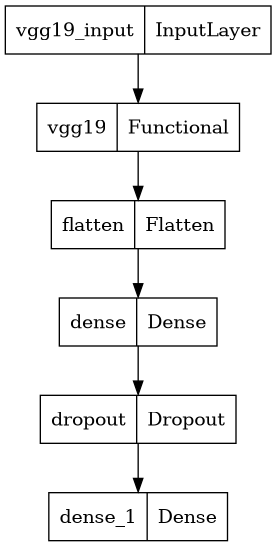

In [13]:
from keras.utils import plot_model
plot_model(fernet, to_file='model.png')

# Callbacks Function

In [14]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

# Training Model

In [15]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
448/448 [==============================] - ETA: 0s - loss: 1.8928 - accuracy: 0.2998
Epoch 1: val_loss improved from inf to 1.53278, saving model to ferNet.h5
448/448 [==============================] - 636s 1s/step - loss: 1.8928 - accuracy: 0.2998 - val_loss: 1.5328 - val_accuracy: 0.4388 - lr: 0.0010
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 1.6256 - accuracy: 0.3503
Epoch 2: val_loss improved from 1.53278 to 1.52324, saving model to ferNet.h5
448/448 [==============================] - 460s 1s/step - loss: 1.6256 - accuracy: 0.3503 - val_loss: 1.5232 - val_accuracy: 0.4196 - lr: 0.0010
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 1.5899 - accuracy: 0.3648
Epoch 3: val_loss improved from 1.52324 to 1.44199, saving model to ferNet.h5
448/448 [==============================] - 453s 1s/step - loss: 1.5899 - accuracy: 0.3648 - val_loss: 1.4420 - val_accuracy: 0.4455 - lr: 0.0010
Epoch 4/60
448/448 [===========================

# Loss and Accuracy Plots

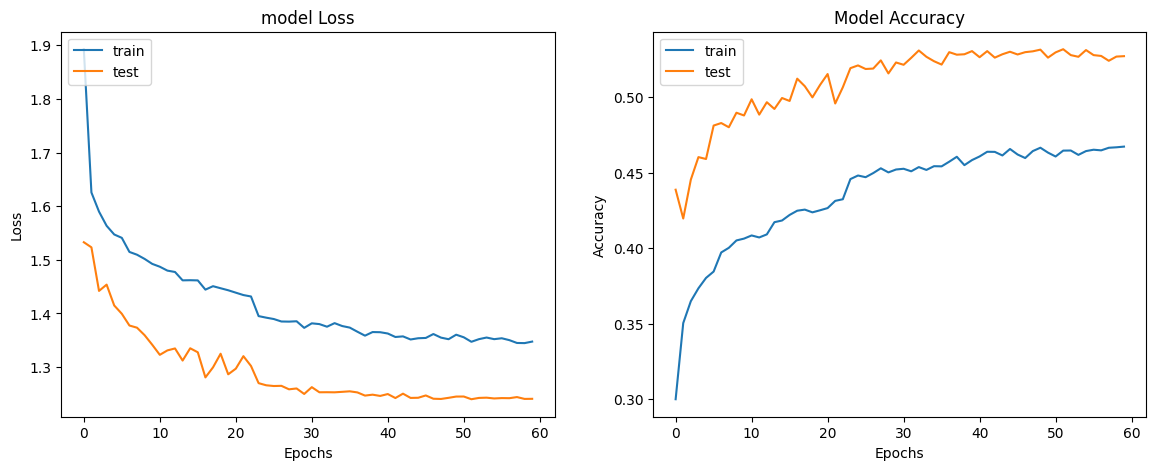

In [16]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

(48, 48)


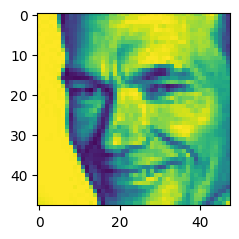

In [17]:
img = load_img("../input/fer2013/test/happy/PrivateTest_12868361.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape)

# Model Evaluation

In [18]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 21s 182ms/step - loss: 50.8522 - accuracy: 0.5276
final train accuracy = 55.88 , validation accuracy = 52.76


In [19]:
fernet.save_weights('fernet_bestweight.h5')

# Confusion Matrix and Classification on Training Set

449/449 [==============================] - 457s 1s/step
Confusion Matrix
[[ 378    0  277 1073  788 1070  409]
 [  44    0   45  108   83  114   42]
 [ 416    0  234 1083  775 1102  487]
 [ 660    0  475 2048 1379 1878  775]
 [ 481    0  342 1374  886 1307  575]
 [ 412    0  302 1394  854 1352  516]
 [ 295    0  255  915  541  832  333]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.09      0.11      3995
     disgust       0.00      0.00      0.00       436
        fear       0.12      0.06      0.08      4097
       happy       0.26      0.28      0.27      7215
     neutral       0.17      0.18      0.17      4965
         sad       0.18      0.28      0.22      4830
    surprise       0.11      0.11      0.11      3171

    accuracy                           0.18     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.18      0.17     28709



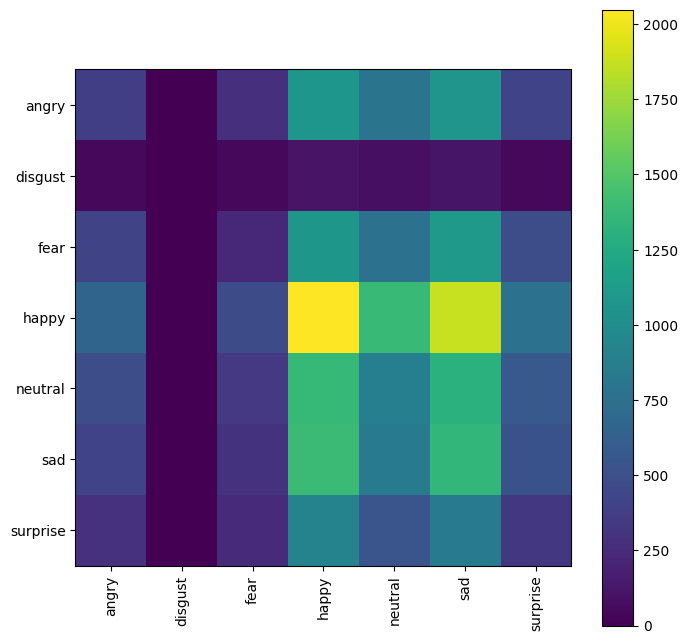

In [20]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

# Confusion Matrix and Classification on Test Set

113/113 [==============================] - 18s 159ms/step
Confusion Matrix
[[110   0  49 274 199 212 114]
 [ 12   0   9  25  24  19  22]
 [112   0  60 297 213 248  94]
 [190   0  98 503 366 426 191]
 [124   0  73 371 231 310 124]
 [126   0  77 353 276 283 132]
 [ 96   0  56 241 161 197  80]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.11      0.13       958
     disgust       0.00      0.00      0.00       111
        fear       0.14      0.06      0.08      1024
       happy       0.24      0.28      0.26      1774
     neutral       0.16      0.19      0.17      1233
         sad       0.17      0.23      0.19      1247
    surprise       0.11      0.10      0.10       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.17      0.18      0.17      7178



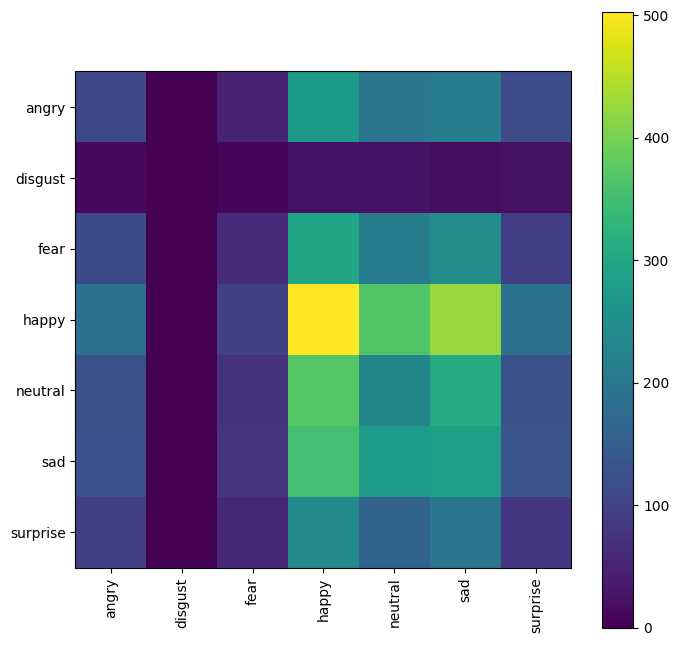

In [21]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)